In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# CycleGAN

#### Directory structure:
- **data/** contains the datasets.
    - **data/&lt;dataset&gt;/{train_A, train_B}/** contains training images for classes A and B.
    - **data/&lt;dataset&gt;/{test_A, test_B}/** contains testing images that are not used during training. These are useful to evaluate the generalization of the model to new data.
- **images/** stores metadata and loss information of each CycleGAN run, as well as evaluation images.
    - **images/meta_data.json** contains the settings of the run.
    - **images/loss_output.csv** contains the various losses of the model, stored after every batch.
    - **images/{train_A, train_B, test_A, test_B}** contains intermediate evaluation images for each epoch, illustrating generator performance.
    - **images/tmp.png** shows example image translations from the current moment in training. This image updates in real time and can be used to see how the training converges.
- **saved_models** stores the generator and discriminator models resulting from each run, which are saved every 20 epochs.

Tomado de:
https://github.com/brainhack101/IntroDL/blob/master/notebooks/2019/Eklund/CycleGAN.ipynb

!rm -rf __pycache__

!wget -nc https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/requirements-gpu.txt

!pip install -r requirements-gpu.txt

In [2]:
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, Conv2DTranspose, Flatten
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


1.14.0


In [3]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
#from sewar.full_ref import msssim

Additional functions are contained in the `helper_functions.py` file. These mostly include code for loading the data and saving the resutls.

!wget https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/helper_funcs.py

In [4]:
#from helper_funcs import *
#from helper_funcs2 import *
from helper_funcs3 import *

If you have multiple GPUs you can select a single one of them by setting the visible CUDA device to 0, 1, ...

#### Load data

The dataset used for the run is **data/&lt;`image_folder`&gt;**.

In [5]:
#image_folder = 'brain' #skullstripped
#image_folder = 'brainv3'
#image_folder = 'brainv4' #bounded
#image_folder = 'healthy' #anomaly detection

#image_folder = 'customnoss'

#image_folder = 'custom-ncct2adc' #NCCT 2 ADC SS
image_folder = 'custom-pruebas'

#image_folder = 'custom-adc2dwi'
#image_folder = 'custom-ncct2dwi'

#image_folder = 'customnoss-ncct2dwi'
#image_folder = 'customnoss-adc2dwi'
#image_folder = 'customnoss-ncct2adc'

#image_folder = 'clinical-ncct2adc-noss'
#image_folder = 'customnoss-ncct2adc'

data = load_data(subfolder=image_folder)

### Model parameters

This CycleGAN implementation allows a lot of freedom on both the training parameters and the network architecture.

In [6]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]

opt['trainA_image_names'] = data["trainA_image_names"]
opt['trainB_image_names'] = data["trainB_image_names"]

#opt['CTFOSCAL_images'] = data["CTFOSCAL_images"]
#opt['CTFOSCAL_image_names'] = data["CTFOSCAL_image_names"]
#opt['CTHEALTHY_images'] = data["CTHEALTHY_images"]
#opt['CTHEALTHY_image_names'] = data["CTHEALTHY_image_names"]

print(opt['A_train'].shape)
print(opt['B_train'].shape)

#print(opt['CTFOSCAL_images'].shape)
#print(len(opt['CTFOSCAL_image_names']))
#print(opt['CTHEALTHY_images'].shape)
#print(len(opt['CTHEALTHY_image_names']))

Image shape:  (256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)


In [7]:
print(opt['A_test'].shape)
print(opt['B_test'].shape)

(1, 256, 256, 1)
(1, 256, 256, 1)


CylceGAN can be used both on paired and unpaired data. The `paired_data` setting affects the presentation of output images as explained above.

In [8]:
#opt['paired_data'] = True
opt['paired_data'] = False

In [9]:
# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 64  # Number of images per batch
opt['epochs'] = 500  # Choose multiples of 20 since the models are saved each 20th epoch

In [10]:
# Output parameters
opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png

In [11]:
# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 100  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator

In [12]:
# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

### Model architecture

#### Layer blocks
These are the individual layer blocks that are used to build the generators and discriminator. More information can be found in the appendix of the [CycleGAN paper](https://arxiv.org/abs/1703.10593).

In [13]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0])

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

#### Architecture functions

In [14]:
def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)

#### CasNet generator

In [15]:
#@title Generator
from keras import layers

def u_block(input_tensor, 
            encoder_num_filters=[64, 128, 256, 512, 512, 512, 512, 512],
            decoder_num_filters=[512, 1024, 1024, 1024, 1024, 512, 256, 128],
            use_instance_norm=True,
            block_prefix=''):
    
    x = input_tensor
    encoder_blocks_outputs = []
    
    # Encoder path.
    for i, num_filters in enumerate(encoder_num_filters):
        x = layers.Conv2D(num_filters, 
                          kernel_size=4, 
                          strides=2, 
                          padding='same', 
                          name=f'{block_prefix}_EncoderBlock{i+1}-Conv')(x)
        if use_instance_norm:
            x = InstanceNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Instancenorm')(x)
        else:
            x = layers.BatchNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Batchnorm')(x)
        x = layers.Activation('relu', name=f'{block_prefix}_EncoderBlock{i+1}-ReLU')(x)
        
        # Append the encoder blocks outputs, except for the last one.
        if i != len(encoder_num_filters) - 1: 
            encoder_blocks_outputs.append(x)

    # Decoder path.
    for i, num_filters in enumerate(decoder_num_filters):
        x = layers.Conv2DTranspose(
            num_filters, 
            kernel_size=(4, 4), 
            strides=(2, 2), 
            padding='same',
            name=f'{block_prefix}_DecoderBlock{i+1}-TransposedConv'
        )(x)
        x = layers.Activation('relu', name=f'{block_prefix}_DecoderBlock{i+1}-ReLU')(x)

        # All the decoder blocks have concatenate the encoder block output with
        # the same spatial dimentions except for the last one.
        if i != len(decoder_num_filters) - 1: 
            x = layers.Concatenate(
                name=f'{block_prefix}_DecoderBlock{i+1}-Concat'
            )([encoder_blocks_outputs[-(i + 1)], x])

    # Last operation: 1x1 conv to map the image to the input n_channels.
    x = layers.Conv2D(1,   #input_tensor.shape[-1]
                      kernel_size=(1, 1), 
                      name=f'{block_prefix}_Decoder-Conv1x1')(x)
    output = layers.Activation('tanh', name=f'{block_prefix}_Decoder-Tanh')(x)

    return output

def build_casnet_generator(input_shape=(256, 256, 1), 
                           n_blocks=2, 
                           use_instance_norm=True,
                           name=None):
    """Create a CasNet Generator using UBlocks"""
    input_tensor = Input(shape=input_shape)
    x = input_tensor
    for i in range(n_blocks):
        x = u_block(x, block_prefix=f'UBlock{i+1}', use_instance_norm=use_instance_norm)
    
    return Model(inputs=input_tensor, outputs=x, name=name)

#### Loss functions
The discriminators use MSE loss. The generators use MSE for the adversarial losses and MAE for the cycle consistency losses.

In [16]:
# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss

#### Build CycleGAN model

In [17]:
model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
print(image_A.shape)
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
#model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
#model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

model['G_A2B'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_A2B_model')
model['G_B2A'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_B2A_model')

print("G_A2B")
#model['G_A2B'].summary()
#print("G_B2A")
#model['G_B2A'].summary()

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')
synthetic_B = model['G_A2B'](real_A)
synthetic_A = model['G_B2A'](real_B)
dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A'](synthetic_B)
reconstructed_B = model['G_A2B'](synthetic_A)

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, real_B],
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

W0502 20:27:02.916008 140607854176064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0502 20:27:02.916997 140607854176064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0502 20:27:02.919508 140607854176064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0502 20:27:03.114367 140607854176064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(?, 256, 256, 1)
G_A2B


#### Folders and configuration

In [ ]:
opt['date_time'] = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + '-' + image_folder

# Output folder for run data and images
opt['out_dir'] = os.path.join('images', opt['date_time'])
if not os.path.exists(opt['out_dir']):
    os.makedirs(opt['out_dir'])

# Output folder for saved models
if opt['save_models']:
    opt['model_out_dir'] = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(opt['model_out_dir']):
        os.makedirs(opt['model_out_dir'])

write_metadata_to_JSON(model, opt)

# Don't pre-allocate GPU memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

### Training function

In [ ]:
def train(model, opt):

    def run_training_batch():

        # ======= Discriminator training ======
        # Generate batch of synthetic images
        synthetic_images_B = model['G_A2B'].predict(real_images_A)
        synthetic_images_A = model['G_B2A'].predict(real_images_B)
        synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)

        # Train discriminators on batch
        D_loss = []
        for _ in range(opt['discriminator_iterations']):
            D_A_loss_real = model['D_A'].train_on_batch(x=real_images_A, y=ones)
            D_B_loss_real = model['D_B'].train_on_batch(x=real_images_B, y=ones)
            D_A_loss_synthetic = model['D_A'].train_on_batch(x=synthetic_images_A, y=zeros)
            D_B_loss_synthetic = model['D_B'].train_on_batch(x=synthetic_images_B, y=zeros)
            D_A_loss = D_A_loss_real + D_A_loss_synthetic
            D_B_loss = D_B_loss_real + D_B_loss_synthetic
            D_loss.append(D_A_loss + D_B_loss)

        # ======= Generator training ==========
        target_data = [real_images_A, real_images_B, ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones

        # Train generators on batch
        G_loss = []
        for _ in range(opt['generator_iterations']):
            G_loss.append(model['G_model'].train_on_batch(
                x=[real_images_A, real_images_B], y=target_data))

        # =====================================

        # Update learning rates
        if opt['use_linear_decay'] and epoch >= opt['decay_epoch']:
            update_lr(model['D_A'], decay_D)
            update_lr(model['D_B'], decay_D)
            update_lr(model['G_model'], decay_G)

        # Store training losses
        D_A_losses.append(D_A_loss)
        D_B_losses.append(D_B_loss)
        D_losses.append(D_loss[-1])

        ABA_reconstruction_loss = G_loss[-1][1]
        BAB_reconstruction_loss = G_loss[-1][2]
        reconstruction_loss = ABA_reconstruction_loss + BAB_reconstruction_loss
        G_AB_adversarial_loss = G_loss[-1][3]
        G_BA_adversarial_loss = G_loss[-1][4]

        ABA_reconstruction_losses.append(ABA_reconstruction_loss)
        BAB_reconstruction_losses.append(BAB_reconstruction_loss)
        reconstruction_losses.append(reconstruction_loss)
        G_AB_adversarial_losses.append(G_AB_adversarial_loss)
        G_BA_adversarial_losses.append(G_BA_adversarial_loss)
        G_losses.append(G_loss[-1][0])

        # Print training status
        print('\n')
        print('Epoch ---------------------', epoch, '/', opt['epochs'])
        print('Loop index ----------------', loop_index + 1, '/', nr_im_per_epoch)
        if opt['discriminator_iterations'] > 1:
            print('  Discriminator losses:')
            for i in range(opt['discriminator_iterations']):
                print('D_loss', D_loss[i])
        if opt['generator_iterations'] > 1:
            print('  Generator losses:')
            for i in range(opt['generator_iterations']):
                print('G_loss', G_loss[i])
        print('  Summary:')
        print('D_lr:', K.get_value(model['D_A'].optimizer.lr))
        print('G_lr', K.get_value(model['G_model'].optimizer.lr))
        print('D_loss: ', D_loss[-1])
        print('G_loss: ', G_loss[-1][0])
        print('reconstruction_loss: ', reconstruction_loss)
        print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index)
        sys.stdout.flush()

        if loop_index % 3*opt['batch_size'] == 0:
            # Save temporary images continously
            save_tmp_images(model, opt, real_images_A[0], real_images_B[0],
                                 synthetic_images_A[0], synthetic_images_B[0])
        
#         if G_loss[-1][0] < best_G_losses[0]:
#             #save_model(opt, model['D_A'], epoch)
#             #save_model(opt, model['D_B'], epoch)
#             print("NEW BEST [G_losses] ", G_loss[-1][0], " old best ", best_G_losses[0])
#             best_G_losses[0] = G_loss[-1][0]
#             save_model(opt, model['G_A2B'], epoch)
#             save_model(opt, model['G_B2A'], epoch)

    # ======================================================================
    # Begin training
    # ======================================================================
    if opt['save_training_img'] and not os.path.exists(os.path.join(opt['out_dir'], 'train_A')):
        os.makedirs(os.path.join(opt['out_dir'], 'train_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'train_B'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_B'))

    D_A_losses = []
    D_B_losses = []
    D_losses = []

    ABA_reconstruction_losses = []
    BAB_reconstruction_losses = []
    reconstruction_losses = []
    G_AB_adversarial_losses = []
    G_BA_adversarial_losses = []
    G_losses = []

    # Image pools used to update the discriminators
    synthetic_pool_A = ImagePool(opt['synthetic_pool_size'])
    synthetic_pool_B = ImagePool(opt['synthetic_pool_size'])

    # Labels used for discriminator training
    label_shape = (opt['batch_size'],) + model['D_A'].output_shape[1:]
    ones = np.ones(shape=label_shape) * opt['REAL_LABEL']
    zeros = ones * 0

    # Linear learning rate decay
    if opt['use_linear_decay']:
        decay_D, decay_G = get_lr_linear_decay_rate(opt)

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_im_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']) * opt['batch_size'])

    # Start stopwatch for ETAs
    start_time = time.time()
    timer_started = False
    
    #best_G_losses = [9999]

    for epoch in range(1, opt['epochs'] + 1):
        # random_order_A = np.random.randint(nr_train_im_A, size=nr_im_per_epoch)
        # random_order_B = np.random.randint(nr_train_im_B, size=nr_im_per_epoch)

        random_order_A = np.concatenate((np.random.permutation(nr_train_im_A),
                                         np.random.randint(nr_train_im_A, size=nr_im_per_epoch - nr_train_im_A)))
        random_order_B = np.concatenate((np.random.permutation(nr_train_im_B),
                                         np.random.randint(nr_train_im_B, size=nr_im_per_epoch - nr_train_im_B)))

        # Train on image batch
        for loop_index in range(0, nr_im_per_epoch, opt['batch_size']):
            indices_A = random_order_A[loop_index:loop_index + opt['batch_size']]
            indices_B = random_order_B[loop_index:loop_index + opt['batch_size']]

            real_images_A = opt['A_train'][indices_A]
            real_images_B = opt['B_train'][indices_B]

            # Train on image batch
            run_training_batch()

            # Start timer after first (slow) iteration has finished
            if not timer_started:
                start_time = time.time()
                timer_started = True

        # Save training images
        if opt['save_training_img'] and epoch % opt['save_training_img_interval'] == 0:
            print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
            save_epoch_images(model, opt, epoch)

        # Save model
        if opt['save_models'] and epoch % 50 == 0:
        #if opt['save_models'] and epoch % 2 == 0:
        #print("ggarzon G_losses", G_losses, "******************")
#         if G_losses < best_G_losses:
#             #save_model(opt, model['D_A'], epoch)
#             #save_model(opt, model['D_B'], epoch)
#             print("NEW BEST [G_losses] ", G_losses)
#             best_G_losses = G_losses
            save_model(opt, model['G_A2B'], epoch)
            save_model(opt, model['G_B2A'], epoch)

        # Save training history
        training_history = {
            'DA_losses': D_A_losses,
            'DB_losses': D_B_losses,
            'G_AB_adversarial_losses': G_AB_adversarial_losses,
            'G_BA_adversarial_losses': G_BA_adversarial_losses,
            'ABA_reconstruction_losses': ABA_reconstruction_losses,
            'BAB_reconstruction_losses': BAB_reconstruction_losses,
            'reconstruction_losses': reconstruction_losses,
            'D_losses': D_losses,
            'G_losses': G_losses}
        write_loss_data_to_file(opt, training_history)

### Train CycleGAN

In [ ]:
train(model, opt)

In [ ]:
save_model(opt, model['G_A2B'], 100)
save_model(opt, model['G_B2A'], 100)

<div style="height:100px;"></div>

### Load weights

In [18]:
#folder = "20230123-090611-custom" #anything
#folder = "20230125-190605-customnoss"
#folder = "20230201-090235-customnoss"

#folder = "20230207-121838-custom-ublocks" #NCCT to ADC ss

#folder = "20230831-104831-v2-noss-adc2dwi" #20230222-111734-customnoss ---> NCCT to DWI ublocks
#folder = "20230223-080355-customnoss" #20230223-080355-customnoss ---> ADC to DWI ublocks

#folder = "20230302-232906-custom-adc2dwi" #20230302-232906-custom-adc2dwi ---> ADC to DWI ublocks ss FAILEDDD
#20230303-090155-custom-ncct2dwi ---> NCCT to DWI ublocks ss (25 epochs)
#folder = "20230303-140156-custom-ncct2dwi" #20230303-140156-custom-ncct2dwi ---> NCCT to DWI ublocks ss (again with 11 epochs)
#folder = "20230303-161154-custom-adc2dwi" #20230303-161154-custom-adc2dwi ---> ADC to DWI

#folder = "20230314-195952-customnoss-ncct2adc" #NCCT to ADC customnoss ----> TO RUN AGAIN !!!!
folder = "20231108-190542-customnoss-ncct2adc" #NCCT to ADC noss ---> epoch19 [BEST], epoch(100)

ep = 19
#checkpoint_path1 = "/data/gustavogarzon/saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
#checkpoint_path2 = "/data/gustavogarzon/saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"

checkpoint_path1 = "saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
checkpoint_path2 = "saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"

# checkpoint_path1 = "saved_models/"+folder+"/G_A2B_model_weights_epoch.hdf5"
# checkpoint_path2 = "saved_models/"+folder+"/G_B2A_model_weights_epoch.hdf5"

model["G_A2B"].load_weights(checkpoint_path1)
model["G_B2A"].load_weights(checkpoint_path2)

W0502 20:27:23.489086 140607854176064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0502 20:27:23.489918 140607854176064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [19]:
len(opt['A_test'])

1

In [20]:
opt['testA_image_names'][0]

'test_032_ncct_14.png'

# CG2 SSIM testing

In [ ]:
data1 = load_data2(subfolder=image_folder, newfolder="batchA_01")
data2 = load_data2(subfolder=image_folder, newfolder="batchA_02")
data3 = load_data2(subfolder=image_folder, newfolder="batchA_03")
data4 = load_data2(subfolder=image_folder, newfolder="batchA_04")

In [ ]:
data1b = load_data2(subfolder=image_folder, newfolder="batchB_01")
data2b = load_data2(subfolder=image_folder, newfolder="batchB_02")
data3b = load_data2(subfolder=image_folder, newfolder="batchB_03")
data4b = load_data2(subfolder=image_folder, newfolder="batchB_04")

In [ ]:
plt.imshow(data2['t_images'][100][...,0], cmap="gray")
plt.show()

In [ ]:
data1["t_images"][0][np.newaxis,:].shape

In [ ]:
print(opt['B_test'][0].shape)
print(opt['B_test'][0][np.newaxis,:].shape)

In [ ]:
all_s1 = []
all_s2 = []
all_s3 = []
all_s4 = []
all_s5 = []
all_s6 = []
all_s7 = []
all_s8 = []

plt.figure(figsize=(15,3))

for k,f in enumerate(data4["t_image_names"]):
    synthetic_images_A = model['G_B2A'].predict(data4["t_images"][k][np.newaxis,:])
    reconstructed_image_B = model['G_A2B'].predict(synthetic_images_A)
    s1 = ssim(data4b["t_images"][k][:,:,0], reconstructed_image_B[0,:,:,0])
    s2 = psnr(data4b["t_images"][k][:,:,0], reconstructed_image_B[0,:,:,0])
    all_s1.append(s1)
    all_s2.append(s2)
    print(f)
#     pts = f.split("_") #train_048_r1_mask_10.png
#     fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[2]
#     #print(fn)
#     s3 = s4 = s5 = s6 = s7 = s8 = 0
#     h_start,h_end,v_start,v_end = maskbox(fn)
#     if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
#         ws = None
#         if opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
#             ws = 3
#         s3 = ssim(opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_B[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
#         s4 = psnr(opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_B[0,h_start:h_end+1,v_start:v_end+1,0])
#         all_s3.append(s3)
#         all_s4.append(s4)

#     print(f.replace("adc","ncct"))
#     image = mpimg.imread("data/"+image_folder+"/testA/"+f.replace("adc","ncct"))
#     ####image = mpimg.imread("data/"+image_folder+"/testA/"+pts[0]+"_"+pts[1]+"_"+pts[3])
#     image = image[:,:,0]
#     image = (image*2)-1
#     plt.figure(figsize=(12,4))
#     plt.subplot(1,3,1)
#     plt.imshow(opt['B_test'][k][:,:,0], cmap="gray")
#     plt.axis('off')
#     plt.subplot(1,3,2)
#     plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
#     plt.axis('off')
#     plt.subplot(1,3,3)
#     plt.imshow(image, cmap="gray")
#     plt.axis('off')
#     #plt.subplot(1,4,4)
#     #plt.imshow(image, cmap="gray")
#     #plt.axis('off')
#     plt.show()
#     #print(np.min(image), np.max(image))
#     #print(np.min(synthetic_images_A), np.max(synthetic_images_A))
#     s5 = ssim(image, synthetic_images_A[0,:,:,0])
#     s6 = psnr(image, synthetic_images_A[0,:,:,0])
    
# #     plt.subplot(1,2,1)
# #     plt.imshow(image, cmap="gray")
# #     plt.subplot(1,2,2)
# #     plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
    
#     all_s5.append(s5)
#     all_s6.append(s6)
    
#     h_start,h_end,v_start,v_end = maskbox(fn)
#     if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
#         ws = None
#         if opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
#             ws = 3
#         s7 = ssim(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_A[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
#         s8 = psnr(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_A[0,h_start:h_end+1,v_start:v_end+1,0])
#         all_s7.append(s7)
#         all_s8.append(s8)
    
#     print(s1, s2, s3, s4, s5, s6, s7, s8)
    #break

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
avg_s3 = np.mean(all_s3)
avg_s4 = np.mean(all_s4)
avg_s5 = np.mean(all_s5)
avg_s6 = np.mean(all_s6)
avg_s7 = np.mean(all_s7)
avg_s8 = np.mean(all_s8)

In [ ]:
print("DWI reconstruction")
print("ssim","\t\tpsnr","\t\tssim-mask","\t\tpsnr-mask")
avg_s1, avg_s2, avg_s3, avg_s4, avg_s5, avg_s6, avg_s7, avg_s8

In [ ]:
for xxx in all_s1:
    print(xxx)

In [ ]:
for xxx in all_s1:
    print(xxx)

In [ ]:
for xxx in all_s1:
    print(xxx)

In [ ]:
for xxx in all_s1:
    print(xxx)

<div style="height:200px;"></div>

In [ ]:
synthetic_images_B = model['G_A2B'].predict(opt['A_test'][18][np.newaxis,:,:,:])
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(opt['A_test'][18][...,0], cmap="gray")
plt.subplot(1,3,2)
plt.imshow(synthetic_images_B[0,...,0], cmap="gray")
# plt.subplot(1,3,3)
# plt.imshow(opt['B_test'][0][...,0], cmap="gray")
plt.savefig("mytest.png", bbox_inches='tight', format="png")
plt.show()

In [ ]:
output_path = "/data/gustavogarzon/backup/cyclegan_tf/data/custom-ncct2adc/synth_adc/"

for idx in range(len(opt['testA_image_names'])):
    synthetic_images_B = model['G_A2B'].predict(opt['A_test'][idx][np.newaxis,:,:,:])
    plt.imsave(os.path.join(output_path,opt['testA_image_names'][idx]), synthetic_images_B[0,...,0], cmap="gray")
    #break

In [ ]:
output_path = "/data/gustavogarzon/backup/cyclegan_tf/data/custom-ncct2adc/synth_adc/"
output_path2 = "/data/gustavogarzon/backup/cyclegan_tf/data/custom-ncct2adc/synth_adc2/"
mylist2 = os.listdir(output_path)
mylist2.sort()

for img in mylist2:
    print(img)
    image = mpimg.imread(os.path.join(output_path, img))
    image = np.rot90(image, axes=(1,0))
    plt.imsave(os.path.join(output_path2,img), image, cmap="gray")
    #break

In [ ]:
import SimpleITK as sitk
import glob
#basepath = '/data/gustavogarzon/backup/cyclegan_tf/data/custom-ncct2adc/synth_adc/'
basepath = '/data/gustavogarzon/backup/cyclegan_tf/data/custom-ncct2adc/synth_adc2/'
mylist = ["ACV-174","ACV-275","ACV-245","ACV-291","ACV-273","ACV-274","ACV-192","ACV-248","ACV-240","ACV-130","ACV-244","ACV-251","ACV-256","ACV-247","ACV-231"]

for fn in mylist:
    print(fn)
    file_names = glob.glob(basepath+fn+'*.png')
    #print(file_names)
    newfn = []
    for myfn in file_names:
        newfn.append(basepath+myfn.split(basepath)[1])
        #print(fn.split(basepath)[1])
    newfn.sort()
    #print(newfn)
    #break
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(newfn)
    vol = reader.Execute()
    #sitk.WriteImage(vol, fn+'.nii.gz')
    outputfile = fn+".nii.gz"
    #print(outputfile)
    sitk.WriteImage(vol, outputfile)
   #break

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(opt['A_test'][10][...,0], cmap="gray")
plt.subplot(1,3,2)
plt.imshow(synthetic_images_B[0,...,0], cmap="gray")
plt.subplot(1,3,3)
plt.imshow(opt['B_test'][6][...,0], cmap="gray")
plt.show()

In [ ]:
for s in range(len(opt['A_test'])):
    synthetic_images_B = model['G_A2B'].predict(opt['A_test'][s][np.newaxis,:,:,:])
    plt.imshow(synthetic_images_B[0,...,0], cmap="gray")
    plt.title(s)
    plt.show()

In [ ]:
def my_cov(a,b):
    ux = np.mean(a)
    uy = np.mean(b)
    dif = 0
    for x in range(a.shape[0]):
        for y in range(a.shape[0]):
            dif += (a[x,y]-ux)*(b[x,y]-uy)
    return dif/(256*256)

In [ ]:
def myssim(y_true, y_pred):
    k1 = 0.01
    k2 = 0.03
    L = 2**200 - 1
    c1 = (k1*L)**2
    c2 = (k2*L)**2
    list_ssim = []
#     for s in range(y_true.shape[0]):        
#         ux = np.mean(y_true[s,:,:,0])
#         uy = np.mean(y_pred[s,:,:,0])
#         varx = np.std(y_true[s,:,:,0])**2
#         vary = np.std(y_pred[s,:,:,0])**2
#         covxy = np.cov(y_true[s,:,:,0],y_pred[s,:,:,0])
#         s = ((2*ux*uy + c1)*(2*covxy + c2))/((ux*ux + uy*uy + c1)*(varx*varx + vary*vary + c2))
#         print("ssim shape:",s.shape)
#         list_ssim.append(s)
    ux = np.mean(y_true)
    uy = np.mean(y_pred)
    varx = np.std(y_true)**2
    vary = np.std(y_pred)**2
    covxy = my_cov(y_true,y_pred)
    print(ux, uy, varx, vary, covxy)
    s = ((2*ux*uy + c1)*(2*covxy + c2))/((ux*ux + uy*uy + c1)*(varx*varx + vary*vary + c2))
#     list_ssim = np.array(list_ssim)
#     #loss = 1 - np.mean(list_ssim)
#     loss = np.mean(list_ssim)
    return s

In [ ]:
a = (opt['B_test'][0][...,0]+1)/2
b = (synthetic_images_B[0,...,0]+1)/2
np.min(a), np.max(a)
np.min(b), np.max(b)

print("covariance:", my_cov(a,b))
print("SSIM:", myssim(a,b))

In [ ]:
synthetic_images_B = model['G_A2B'].predict(opt['A_test'][0][np.newaxis,:,:,:])
plt.subplot(1,3,1)
plt.imshow(opt['A_test'][0][...,0], cmap="gray")
plt.subplot(1,3,2)
plt.imshow(synthetic_images_B[0,...,0], cmap="gray")
plt.subplot(1,3,3)
plt.imshow(opt['B_test'][0][...,0], cmap="gray")
plt.show()

<div style="height:100px;"></div>

## Save translated images

In [ ]:
for k,img in enumerate(opt['A_test']):
    print(opt['testA_image_names'][k])
    #print(opt['A_test'][k].shape)
    synthetic_images_B = model['G_A2B'].predict(opt['A_test'][k][np.newaxis,:,:,:])
    #print(synthetic_images_B.shape)
    reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)
    #plt.imsave("data/foscal/imgA/"+opt['testA_image_names'][k], synthetic_images_B[0,:,:,0], cmap="gray")
    plt.figure(figsize=(15,20))
    plt.subplot(4,3,1)
    plt.imshow(opt['A_test'][k][:,:,0], cmap="gray")
    plt.subplot(4,3,2)
    plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
    plt.subplot(4,3,3)
    plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
    plt.imsave("train_048_10_dwi-synth.png", synthetic_images_B[0,:,:,0], cmap="gray")
    plt.show()
    break

<div style="height:100px;"></div>

In [21]:
#imgxxx = opt['testB_image_names'][0]
#fn = "train_049_r1_mask_15.png"
#print(fn)
#pts = imgxxx.split("_") #train_048_r1_mask_10.png
#fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[2]
#print(fn)

#print(image.shape)

def maskbox(fn):
    imgpath = "data-old/customnoss/testmaskB/"+fn
    image = mpimg.imread(imgpath)
    h_start = 0
    h_end = 0
    v_start = 0
    v_end = 0
    for kk,p in enumerate(np.sum(image[:,:,0], axis=0)):
        if(p!=0):
            h_start = kk
            print(kk)
            break
    for p in range(255,0,-1):
        if(np.sum(image[:,:,0], axis=0)[p]!=0):
            h_end = p
            print(p)
            break
    for kk,p in enumerate(np.sum(image[:,:,0], axis=1)):
        if(p!=0):
            v_start = kk
            print(kk)
            break
    for p in range(255,0,-1):
        if(np.sum(image[:,:,0], axis=1)[p]!=0):
            v_end = p
            print(p)
            break
    return h_start,h_end,v_start,v_end

In [ ]:
all_s1 = []
all_s2 = []
all_s3 = []
all_s4 = []
all_s5 = []
all_s6 = []
all_s7 = []
all_s8 = []

plt.figure(figsize=(15,3))

for k,f in enumerate(opt['testB_image_names']):
    synthetic_images_A = model['G_B2A'].predict(opt['B_test'][k][np.newaxis,:])
    reconstructed_image_B = model['G_A2B'].predict(synthetic_images_A)
    s1 = ssim(opt['B_test'][k][:,:,0], reconstructed_image_B[0,:,:,0])
    s2 = psnr(opt['B_test'][k][:,:,0], reconstructed_image_B[0,:,:,0])
    all_s1.append(s1)
    all_s2.append(s2)
    print(f)
    pts = f.split("_") #train_048_r1_mask_10.png
    fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[2]
    #print(fn)
    s3 = s4 = s5 = s6 = s7 = s8 = 0
    h_start,h_end,v_start,v_end = maskbox(fn)
    if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
        ws = None
        if opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
            ws = 3
        s3 = ssim(opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_B[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
        s4 = psnr(opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_B[0,h_start:h_end+1,v_start:v_end+1,0])
        all_s3.append(s3)
        all_s4.append(s4)

    print(f.replace("adc","ncct"))
    image = mpimg.imread("data/"+image_folder+"/testA/"+f.replace("adc","ncct"))
    ####image = mpimg.imread("data/"+image_folder+"/testA/"+pts[0]+"_"+pts[1]+"_"+pts[3])
    image = image[:,:,0]
    image = (image*2)-1
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(opt['B_test'][k][:,:,0], cmap="gray")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    #plt.subplot(1,4,4)
    #plt.imshow(image, cmap="gray")
    #plt.axis('off')
    plt.show()
    #print(np.min(image), np.max(image))
    #print(np.min(synthetic_images_A), np.max(synthetic_images_A))
    s5 = ssim(image, synthetic_images_A[0,:,:,0])
    s6 = psnr(image, synthetic_images_A[0,:,:,0])
    
#     plt.subplot(1,2,1)
#     plt.imshow(image, cmap="gray")
#     plt.subplot(1,2,2)
#     plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
    
    all_s5.append(s5)
    all_s6.append(s6)
    
    h_start,h_end,v_start,v_end = maskbox(fn)
    if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
        ws = None
        if opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
            ws = 3
        s7 = ssim(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_A[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
        s8 = psnr(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_A[0,h_start:h_end+1,v_start:v_end+1,0])
        all_s7.append(s7)
        all_s8.append(s8)
    
    print(s1, s2, s3, s4, s5, s6, s7, s8)
    #break

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
avg_s3 = np.mean(all_s3)
avg_s4 = np.mean(all_s4)
avg_s5 = np.mean(all_s5)
avg_s6 = np.mean(all_s6)
avg_s7 = np.mean(all_s7)
avg_s8 = np.mean(all_s8)

In [ ]:
print("DWI reconstruction")
print("ssim","\t\tpsnr","\t\tssim-mask","\t\tpsnr-mask")
avg_s1, avg_s2, avg_s3, avg_s4, avg_s5, avg_s6, avg_s7, avg_s8

In [ ]:
avg_s5, np.std(all_s5), avg_s6, np.std(all_s6)

In [ ]:
avg_s7, np.std(all_s7), avg_s8, np.std(all_s8)

In [ ]:
all_s1 = []
all_s2 = []
all_s3 = []
all_s4 = []
all_s5 = []
all_s6 = []
all_s7 = []
all_s8 = []

for k,f in enumerate(opt['testA_image_names']):
    print("------", k, opt['testA_image_names'][k])
    synthetic_images_B = model['G_A2B'].predict(opt['A_test'][k][np.newaxis,:])
    reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)
    s1 = ssim(opt['A_test'][k][:,:,0], reconstructed_image_A[0,:,:,0])
    s2 = psnr(opt['A_test'][k][:,:,0], reconstructed_image_A[0,:,:,0])
    all_s1.append(s1)
    all_s2.append(s2)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(opt['A_test'][k][:,:,0], cmap="gray")
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
    #plt.imshow(opt['A_test'][k][:,:,0]-reconstructed_image_A[0,:,:,0], cmap="plasma")
    plt.axis('off')
    plt.show()
    print(f)
    pts = f.split("_") #train_048_r1_mask_10.png
    fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[2]
    print(fn)
    s3 = s4 = 0
    if os.path.isfile("data-old/customnoss/testmaskB/"+fn):
        h_start,h_end,v_start,v_end = maskbox(fn)
        if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
            ws = None
            if opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
                ws = 3
            s3 = ssim(opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_A[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
            s4 = psnr(opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_A[0,h_start:h_end+1,v_start:v_end+1,0])
            all_s3.append(s3)
            all_s4.append(s4)
        #print(s1, s2, s3, s4)
    else:
        print("MASK error in: ",fn)
    
    s5 = s6 = s7 = s8 = 0
    fnewx = f.replace("ncct","adc")
    ####fnewx = pts[0]+"_"+pts[1]+"_dwi_"+pts[2]
    print("paired:",fnewx)
    if os.path.isfile("data/"+image_folder+"/testB/"+fnewx):
        image = mpimg.imread("data/"+image_folder+"/testB/"+fnewx)
        image = image[:,:,0]
        image = (image*2)-1
        s5 = ssim(image, synthetic_images_B[0,:,:,0])
        s6 = psnr(image, synthetic_images_B[0,:,:,0])
        all_s5.append(s5)
        all_s6.append(s6)
#         plt.subplot(1,4,1)
#         plt.imshow(image, cmap="gray")
#         plt.subplot(1,4,2)
#         plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
# #         plt.subplot(1,4,3)
# #         plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
# #         plt.subplot(1,4,4)
# #         plt.imshow(opt['A_test'][k][:,:,0], cmap="gray")
#         plt.show()
        if os.path.isfile("data-old/customnoss/testmaskB/"+fn):
            h_start,h_end,v_start,v_end = maskbox(fn)
            if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
                ws = None
                if image[h_start:h_end+1,v_start:v_end+1].shape[0]<7 or image[h_start:h_end+1,v_start:v_end+1].shape[1]<7:
                    ws = 3
                s7 = ssim(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_B[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
                s8 = psnr(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_B[0,h_start:h_end+1,v_start:v_end+1,0])
                all_s7.append(s7)
                all_s8.append(s8)
        #break
    else:
        print("ADC error in: ",f)

    print(s1, s2, s3, s4, s5, s6, s7, s8)
    #print(s1, s2)
    #break

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
avg_s3 = np.mean(all_s3)
avg_s4 = np.mean(all_s4)
avg_s5 = np.mean(all_s5)
avg_s6 = np.mean(all_s6)
avg_s7 = np.mean(all_s7)
avg_s8 = np.mean(all_s8)

In [ ]:
print("ADC reconstruction")
print("ssim","\t\tpsnr","\t\tssim-mask","\t\tpsnr-mask")
avg_s1, avg_s2, avg_s3, avg_s4, avg_s5, avg_s6, avg_s7, avg_s8

In [ ]:
avg_s5, np.std(all_s5), avg_s6, np.std(all_s6)

In [ ]:
avg_s7, np.std(all_s7), avg_s8, np.std(all_s8)

<div style="height:100px;"></div>

### NCCT - ADC - Synth(ADC) - AbsDiff (CUSTOM)

49
129
126
167
(256, 256, 4)
(1, 256, 256, 1)


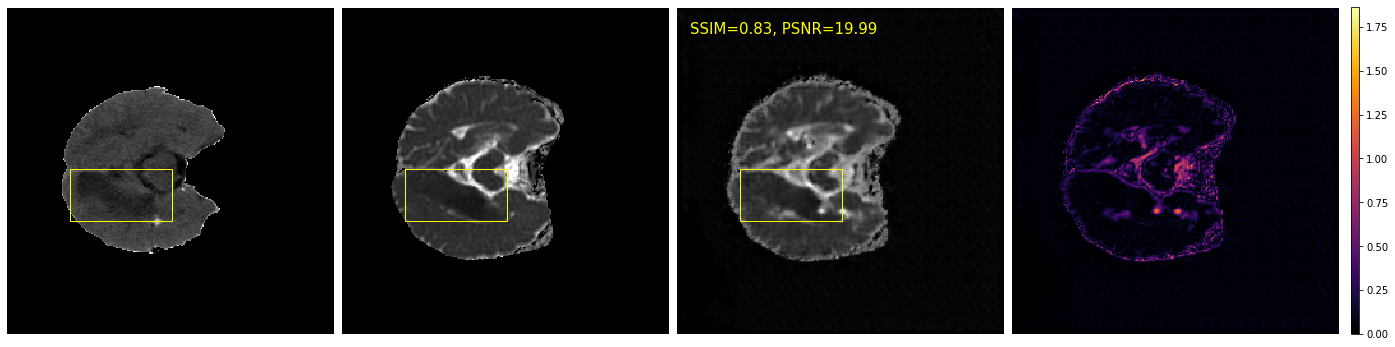

0.8629642938666074 24.712696214776976


In [31]:
#pathimg = "data/custom-ncct2adc/testA/train_054_ncct_10.png"
#img = mpimg.imread(pathimg)

fn = "train_054_r1_mask_10.png"
h_start,h_end,v_start,v_end = maskbox(fn)

#pathimg2 = "data/custom-ncct2adc/testB/train_054_adc_10.png"
pathimg2 = "data/custom-ncct2adc/trainB/train_054_adc_10.png"
img2 = mpimg.imread(pathimg2)
img2 = (img2*2)-1

#img = opt['A_test'][150]
pathimg1 = "data/custom-ncct2adc/trainA/train_054_ncct_10.png"
img = mpimg.imread(pathimg1)
img = (img*2)-1

synthetic_images_B = model['G_A2B'].predict(img2[np.newaxis,:,:,:1])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)
print(img.shape)
print(reconstructed_image_A.shape)

plt.figure(figsize=(24,6))

plt.subplot(1,4,1)
plt.imshow(img[:,:,0], cmap="gray")
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(img2[:,:,0], cmap="gray")
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.text(10,20,"SSIM=0.83, PSNR=19.99", color="yellow", size=15)
plt.axis('off')

plt.subplot(1,4,4)
#plt.imshow(img2[:,:,0]-synthetic_images_B[0,:,:,0], cmap="inferno", vmin=-1, vmax=1)
plt.imshow(np.abs(img2[:,:,0]-synthetic_images_B[0,:,:,0]), cmap="inferno")
plt.axis('off')

cax = plt.axes([0.905, 0.125, 0.005, 0.757])
plt.colorbar(cax=cax)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("ncct2adc.png", pad_inches=0, bbox_inches='tight')
plt.show()

s1 = ssim(img2[:,:,0], synthetic_images_B[0,:,:,0])
s2 = psnr(img2[:,:,0], synthetic_images_B[0,:,:,0])
print(s1,s2)

137
186
150
189
(1, 256, 256, 1)


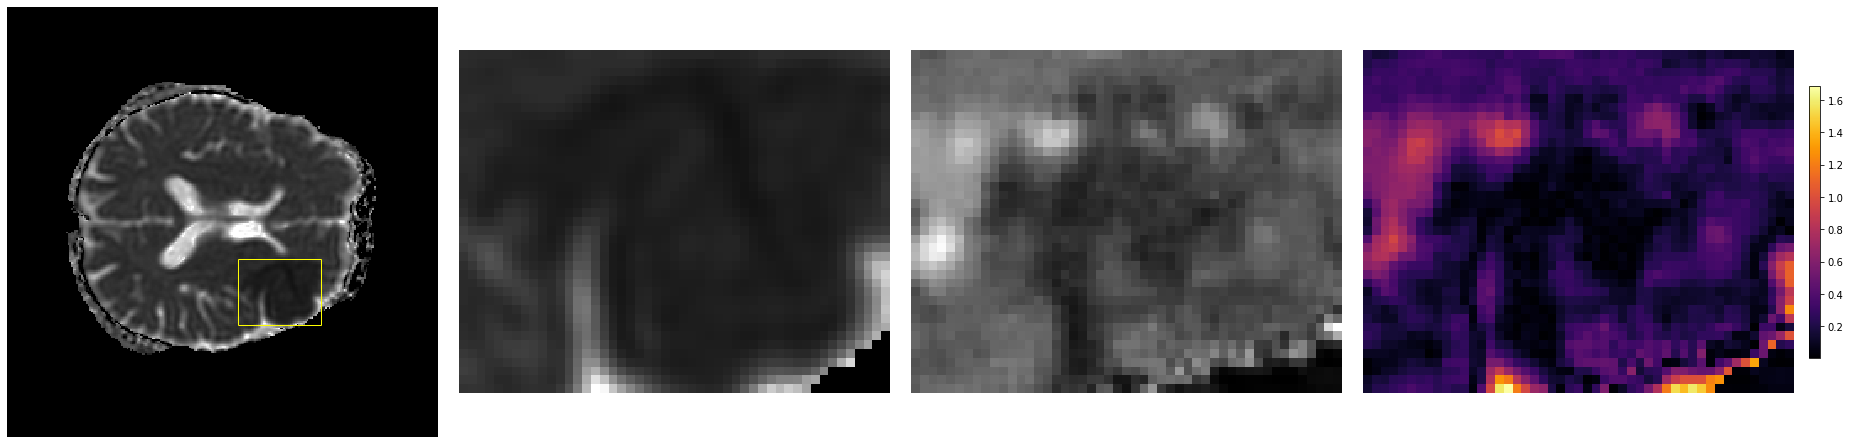

0.23229362002875992 15.169007251899913


In [30]:
fn = "train_053_r1_mask_15.png"
h_start,h_end,v_start,v_end = maskbox(fn)

pathimg = "data-old/foscal/maskA/train_053_mask_15.png"
imgmask = mpimg.imread(pathimg)

pathimg2 = "data/custom-ncct2adc/trainB/train_053_adc_15.png"
img2 = mpimg.imread(pathimg2)
img2 = (img2*2)-1

pathimg1 = "data/custom-ncct2adc/trainA/train_053_ncct_15.png"
img = mpimg.imread(pathimg1)
img = (img*2)-1

# img = opt['B_test'][131]
synthetic_images_B = model['G_B2A'].predict(img2[np.newaxis,:,:,:1])
#reconstructed_image_A = model['G_A2B'].predict(synthetic_images_B)
reconstructed_image_A = model['G_A2B'].predict(img[np.newaxis,:,:,:1])
# print(img.shape)
print(reconstructed_image_A.shape)

plt.figure(figsize=(32,8))

# plt.subplot(1,5,1)
# plt.imshow(img2[:,:,0], cmap="gray")
# plt.imshow(imgmask[:,:,0], cmap="gray", alpha=0.8)
# plt.axis('off')

plt.subplot(1,4,1)
plt.imshow(img2[:,:,0], cmap="gray")
#plt.imshow(imgmask[:,:,0], cmap="gray", alpha=0.1)
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img2[v_start:v_end,h_start:h_end,0], cmap="gray")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(reconstructed_image_A[0,v_start:v_end,h_start:h_end,0], cmap="gray")
# plt.text(1.5,3,"SSIM=0.74, PSNR=24.10", color="yellow", size=14)
plt.axis('off')

plt.subplot(1,4,4)
# plt.imshow(reconstructed_image_A[0,v_start:v_end,h_start:h_end,0]-img2[v_start:v_end,h_start:h_end,0], cmap="inferno", vmin=-1, vmax=1)
plt.imshow(np.abs(reconstructed_image_A[0,v_start:v_end,h_start:h_end,0]-img2[v_start:v_end,h_start:h_end,0]), cmap="inferno")
plt.axis('off')
cax = plt.axes([0.907, 0.265, 0.005, 0.473])
plt.colorbar(cax=cax)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig("ncct2adc-mask.png", pad_inches=0, bbox_inches='tight')
plt.show()

s1 = ssim(img2[v_start:v_end,h_start:h_end,0], reconstructed_image_A[0,v_start:v_end,h_start:h_end,0])
s2 = psnr(img2[v_start:v_end,h_start:h_end,0], reconstructed_image_A[0,v_start:v_end,h_start:h_end,0])
print(s1,s2)

In [ ]:
a = img2[:,:,0]
b = synthetic_images_B[0,:,:,0]
s1 = ssim(a, b)
s2 = psnr(a, b)
print(s1, s2)

print(np.min(img2[:,:,0]), np.max(img2[:,:,0]))
print(np.min(synthetic_images_B[0,:,:,0]), np.max(synthetic_images_B[0,:,:,0]))

a = img2[v_start:v_end,h_start:h_end,0]
b = reconstructed_image_A[0,v_start:v_end,h_start:h_end,0]
s1 = ssim(a, b)
s2 = psnr(a, b)
print(s1, s2)

In [ ]:
import keras

synthetic_images_B = model['G_A2B'].predict(opt['A_test'])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)
plt.figure(figsize=(15,20))
plt.subplot(4,3,1)
plt.imshow(opt['A_test'][0,:,:,0], cmap="gray")
plt.subplot(4,3,2)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,3)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
plt.show()

In [ ]:
all_s1 = []
all_s2 = []
#all_s3 = []
#all_s4 = []

for k,f in enumerate(opt['testA_image_names']):
    synthetic_images_B = model['G_A2B'].predict(opt['A_test'][k][np.newaxis,:])
    reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)
    s1 = ssim(opt['A_test'][k][:,:,0], reconstructed_image_A[0,:,:,0])
    s2 = psnr(opt['A_test'][k][:,:,0], reconstructed_image_A[0,:,:,0])
    all_s1.append(s1)
    all_s2.append(s2)
    print(f)
    #pts = f.split("_") #train_048_r1_mask_10.png
    #fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[2]
    s3 = s4 = 0
    """h_start,h_end,v_start,v_end = maskbox(fn)
    if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
        ws = None
        if opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
            ws = 3
        s3 = ssim(opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_A[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
        s4 = psnr(opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_A[0,h_start:h_end+1,v_start:v_end+1,0])
        all_s3.append(s3)
        all_s4.append(s4)"""
    print(s1, s2, s3, s4)
    #break

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
#avg_s3 = np.mean(all_s3)
#avg_s4 = np.mean(all_s4)

In [ ]:
print("NCCT reconstruction")
print("ssim","\t\tpsnr","\t\tssim-mask","\t\tpsnr-mask")
#avg_s1, avg_s2, avg_s3, avg_s4
avg_s1, avg_s2

<div style="height:100px;"></div>

## Single image embedding

In [ ]:
capa_o2 = keras.models.Model(inputs=model["G_B2A"].get_input_at(0), outputs=model["G_B2A"].get_layer('UBlock1_EncoderBlock8-ReLU').output)
emb2 = capa_o2.predict(newimage)
print(emb2.shape)

## Calculating embeddings

In [ ]:
opt["A_alldata"] = np.concatenate([opt["A_train"], opt["A_test"]], axis=0)
opt["A_alldata"].shape

In [ ]:
opt["B_alldata"] = np.concatenate([opt["B_train"], opt["B_test"]], axis=0)
opt["B_alldata"].shape

In [ ]:
opt["A_image_names"] = opt["trainA_image_names"]+opt["testA_image_names"]
len(opt["A_image_names"])

In [ ]:
opt["B_image_names"] = opt["trainB_image_names"]+opt["testB_image_names"]
len(opt["B_image_names"])

In [ ]:
genmodel = "G_B2A"
#genmodel = "G_A2B"

#myset = "B_train"
myset = "B_alldata"
#myset = "A_train"
#myset = "A_alldata"

capa_o2 = keras.models.Model(inputs=model[genmodel].get_input_at(0), outputs=model[genmodel].get_layer('UBlock1_EncoderBlock8-ReLU').output)
emb2 = capa_o2.predict(opt[myset])

emb2 = emb2[:,0,0,:]
print(emb2.shape)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
comp = pca.fit_transform(emb2)

In [ ]:
import umap

um = umap.UMAP(random_state=0).fit_transform(emb2)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(emb2)

In [ ]:
import pandas as pd

d = pd.read_csv("mask_index.csv")
#print(d.head())

comp_s = []
comp_ns = []
tsne_s = []
tsne_ns = []
um_s = []
um_ns = []

if myset.split("_")[0]=="A":
    if myset.split("_")[1]=="train":
        names = opt["trainA_image_names"]
    elif myset.split("_")[1]=="test":
        names = opt["testA_image_names"]
    else:
        names = opt["A_image_names"]
else:
    if myset.split("_")[1]=="train":
        names = opt["trainB_image_names"]
    elif myset.split("_")[1]=="test":
        names = opt["testB_image_names"]
    else:
        names = opt["B_image_names"]

for k,im in enumerate(names):
    parts = im.split("_")
    im = parts[0]+"_"+parts[1]+"_adc_"+parts[2]
    res = d.loc[d["ADC"]==im]["MASK"].values[0]
    if res==1:
        #print("MASKED:",im)
        comp_s.append([comp[k,0], comp[k,1]])
        tsne_s.append([tsne[k,0], tsne[k,1]])
        um_s.append([um[k,0], um[k,1]])
    else:
        #print(im)
        comp_ns.append([comp[k,0], comp[k,1]])
        tsne_ns.append([tsne[k,0], tsne[k,1]])
        um_ns.append([um[k,0], um[k,1]])

comp_s = np.array(comp_s)
comp_ns = np.array(comp_ns)
tsne_s = np.array(tsne_s)
tsne_ns = np.array(tsne_ns)
um_s = np.array(um_s)
um_ns = np.array(um_ns)

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(tsne[:,0], tsne[:,1], label="ADC - TSNE", alpha=0.8, s=10, marker=".", color="#FF0000")
plt.scatter(comp[:,0], comp[:,1], label="ADC - PCA", alpha=0.8, s=10, marker=".", color="#0000FF")
plt.scatter(um[:,0], um[:,1], label="ADC - UMAP", alpha=0.8, s=10, marker=".", color="#000000")

plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.savefig("plot-all-e"+str(ep)+"-"+genmodel+".pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(comp_s[:,0], comp_s[:,1], label="Ischemic - PCA", alpha=0.9, s=30, marker=".", color="#FF0000")
plt.scatter(comp_ns[:,0], comp_ns[:,1], label="normal - PCA", alpha=0.9, s=30, marker="+", color="#0000FF")

#plt.scatter(um[:,0], um[:,1], label="ADC - UMAP", alpha=0.2, s=10, marker=".", color="#000000")

plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.savefig("plot-e"+str(ep)+"_PCA_"+genmodel+".pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(tsne_s[:,0], tsne_s[:,1], label="Ischemic - TSNE", alpha=0.9, s=30, marker=".", color="#FF0000")
plt.scatter(tsne_ns[:,0], tsne_ns[:,1], label="normal - TSNE", alpha=0.9, s=30, marker="+", color="#0000FF")
#plt.scatter(comp[:,0], comp[:,1], label="ADC - PCA", alpha=0.8, s=10, marker=".", color="#0000FF")
#plt.scatter(um[:,0], um[:,1], label="ADC - UMAP", alpha=0.2, s=10, marker=".", color="#000000")

plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.savefig("plot-e"+str(ep)+"_TSNE_"+genmodel+".pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(um_s[:,0], um_s[:,1], label="Ischemic - UMAP", alpha=0.9, s=30, marker=".", color="#FF0000")
plt.scatter(um_ns[:,0], um_ns[:,1], label="normal - UMAP", alpha=0.9, s=30, marker="+", color="#0000FF")

plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.savefig("plot-e"+str(ep)+"_UMAP_"+genmodel+".pdf", bbox_inches="tight")
plt.show()

<div style="height:300px"></div>

In [ ]:
#test_images_A = opt['A_train'][101]
test_images_A = opt['A_test'][33]
test_images_B = opt['B_train'][1]
print(opt['A_train'].shape)
print(opt['B_train'].shape)
print(opt['trainA_image_names'][1])

synthetic_images_B = model['G_A2B'].predict(test_images_A[np.newaxis,:])
reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

synthetic_images_A = model['G_B2A'].predict(test_images_B[np.newaxis,:])
reconstructed_image_B = model['G_A2B'].predict(synthetic_images_A)

plt.figure(figsize=(15,20))
plt.subplot(4,3,1)
plt.imshow(test_images_A[:,:,0], cmap="gray")
plt.subplot(4,3,2)
plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
plt.subplot(4,3,3)
plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")

plt.subplot(4,3,4)
plt.imshow(test_images_B[:,:,0], cmap="gray")
plt.subplot(4,3,5)
plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
plt.subplot(4,3,6)
plt.imshow(reconstructed_image_B[0,:,:,0], cmap="gray")


#CTHEALTHY_images_A = opt['CTHEALTHY_images'][1]

#synthetic_images_B = model['G_A2B'].predict(CTHEALTHY_images_A[np.newaxis,:])
#reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

#plt.subplot(4,3,7)
#plt.imshow(CTHEALTHY_images_A[:,:,0], cmap="gray")
#plt.subplot(4,3,8)
#plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
#plt.subplot(4,3,9)
#plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")


#CTFOSCAL_images_A = opt['CTFOSCAL_images'][10]

#synthetic_images_B = model['G_A2B'].predict(CTFOSCAL_images_A[np.newaxis,:])
#reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)

#plt.subplot(4,3,10)
#plt.imshow(CTFOSCAL_images_A[:,:,0], cmap="gray")
#plt.subplot(4,3,11)
#plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
#plt.subplot(4,3,12)
#plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")

plt.show()

# Training data

In [ ]:
import keras
import seaborn as sns

capa_o = keras.models.Model(inputs=model["G_A2B"].get_input_at(0), outputs=model["G_A2B"].get_layer('UBlock1_EncoderBlock8-ReLU').output)
capa_o2 = keras.models.Model(inputs=model["G_B2A"].get_input_at(0), outputs=model["G_B2A"].get_layer('UBlock1_EncoderBlock8-ReLU').output)

In [ ]:
synthetic_images_B = model['G_A2B'].predict(opt['A_train'])

print(opt['trainA_image_names'][0])

emb = capa_o.predict(synthetic_images_B)
print("emb", emb[:,0,0,:].shape, emb.shape)

emb2 = capa_o2.predict(opt['B_train'])
print("emb2", emb2[:,0,0,:].shape)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
comp = pca.fit_transform(emb[:,0,0,:])

pca2 = PCA(n_components=2)
comp2 = pca2.fit_transform(emb2[:,0,0,:])

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

d = pd.read_csv("data/xxx2.csv")

mb_list = []
mb_synth_ns = []
mb_synth_stroke = []

#data_isles2018["t_image_names"]

#print(d.head())
print(opt['trainA_image_names'][0])
print("trainA", len(opt['trainA_image_names']))
print("trainB", len(opt['trainB_image_names']))

print(type(comp))
#for i in range(len(opt['trainA_image_names'])):
#for i in range(len(opt['trainA_image_names'])):
#    #fname, comp[i,0], comp[i,1], maskbin
#    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
#    if (list(d.loc[d["CT"] == data_isles2018["t_image_names"][i]]["maskbin"])[0]==0):
#        mb_synth_ns.append([comp[i,0], comp[i,1]])
#    else:
#        mb_synth_stroke.append([comp[i,0], comp[i,1]])

#mb_synth_ns = np.array(mb_synth_ns)
#mb_synth_stroke = np.array(mb_synth_stroke)

#d = {'files': data_isles2018["t_image_names"], 'maskbin': mb_list, 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
#d = pd.DataFrame(data=d)

sns.reset_defaults()
plt.figure(figsize=(10,4))
plt.rcParams['axes.edgecolor'] = '#CCCCCC'


plt.scatter(comp[:,0], comp[:,1], label="Foscal t0", alpha=0.5, s=40, marker="+", color="#0000FF")
plt.scatter(comp2[:,0], comp2[:,1], label="Foscal t1", alpha=0.5, s=40, marker=".", color="#FF6600")
#plt.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], label="Synthetic IS (no lesion)", alpha=0.8, s=40, marker="+", color="#FF6600")
#plt.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], label="Synthetic IS", alpha=0.8, s=20, marker=".", color="#FF6600")

#plt.scatter(comp[:,0], comp[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.8, s=5, color="#0000FF")
#plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic FOSCAL", alpha=0.6, s=20, color="#555555", marker="x")
#plt.xticks(np.arange(-3, 20, 1))
plt.legend(framealpha=0.5)

plt.xticks([], [])
plt.yticks([], [])
#plt.xlim((-0.2,0.2))
#plt.ylim((-0.1, 0.1))
#ax.xaxis.label.set_color('yellow')
#plt.savefig("plot01.pdf", bbox_inches="tight")
plt.savefig("plot-foscal-t0t1t2-v1-e"+str(ep)+".png", bbox_inches="tight")
#plt.savefig("plot01-v3-e"+str(ep)+".png", bbox_inches="tight")
#plt.savefig("plot01-v4-bounded-e"+str(ep)+".png", bbox_inches="tight")
#plt.savefig("plot02.pdf", bbox_inches="tight")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
a = mpimg.imread("../FastGAN-pytorch/apis2/train_000_10.png")
print(a.shape)
plt.imshow(a)
plt.show()

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [ ]:
def window_image(image, window_center=60, window_width=120):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

In [ ]:
def min_max_normalization(data: np.ndarray) -> np.ndarray:
    """Returns a min-max normalized data array. The values for the
    normalized array will lie between 0 and 1.

    Args:
        data (np.ndarray): array to be normalized

    Returns:
        np.ndarray: Normalized data
    """
    min = data.min()
    max = data.max()
    return (data - min) / (max - min)

In [ ]:
mypath = "/data/Datasets/stroke/clinical_validation"
mypath_output = "dicom"
#mylist = ["ACV-281","ACV-246","ACV-288","ACV-224","ACV-268","ACV-260","ACV-267","ACV-252","ACV-226","ACV-269","ACV-237","ACV-106","ACV-289","ACV-229","ACV-285"]
mylist = ["ACV-174","ACV-275","ACV-245","ACV-291","ACV-273","ACV-274","ACV-192","ACV-248","ACV-240","ACV-130","ACV-244","ACV-251","ACV-256","ACV-247","ACV-231"]
png_output = "/data/gustavogarzon/backup/cyclegan_tf/data/custom-ncct2adc/testA/"

In [ ]:
for fn in mylist:
    print(fn)
    nifti_img1 = nib.load(os.path.join(mypath,fn,fn+"_NCCT.nii.gz")).get_fdata()
    #nifti_img2 = nib.load(os.path.join(mypath,fn,fn+"_ADC.nii.gz")).get_fdata()
    nifti_img1 = window_image(nifti_img1)
    #nifti_img1 = resize(nifti_img1, (512,512))
    #nifti_img2 = resize(nifti_img2, (512,512))
    for s in range(nifti_img1.shape[2]):
        #mymixed = np.hstack((min_max_normalization(nifti_img1[:,:,s]),min_max_normalization(nifti_img2[...,s])))
        #mymixed = nifti_img1[...,s]
        plt.imsave(png_output+fn+"_"+str(s+1).zfill(3)+".png", nifti_img1[:,:,s], cmap="gray")
    #break